## 1. Import Libraries và Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
from pathlib import Path
import struct

# Import model
sys.path.append('./model')
from model.SoftmaxRegression import SoftmaxRegression

# Hàm đọc file MNIST IDX format
def load_mnist_images(filename):
    """Đọc file MNIST images (idx3-ubyte format)"""
    with open(filename, 'rb') as f:
        # Đọc header
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        # Đọc pixel data
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    return images

def load_mnist_labels(filename):
    """Đọc file MNIST labels (idx1-ubyte format)"""
    with open(filename, 'rb') as f:
        # Đọc header
        magic, num_labels = struct.unpack('>II', f.read(8))
        # Đọc label data
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load MNIST data từ file IDX format
x_train_flat = load_mnist_images('./data/train-images.idx3-ubyte')
y_train = load_mnist_labels('./data/train-labels.idx1-ubyte')

x_test_flat = load_mnist_images('./data/t10k-images.idx3-ubyte')
y_test = load_mnist_labels('./data/t10k-labels.idx1-ubyte')

# Normalize pixel values về [0, 1]
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

print(f"Training set: {x_train_flat.shape}")
print(f"Test set: {x_test_flat.shape}")
print(f"Labels: {np.unique(y_train)}")

Training set: (60000, 784)
Test set: (10000, 784)
Labels: [0 1 2 3 4 5 6 7 8 9]


## 2. Định nghĩa Feature Extraction Functions

Sử dụng các hàm tương tự như trong `feature_design.ipynb`

In [3]:
def add_bias_column(X):
    """Thêm cột bias (toàn 1) vào feature matrix"""
    return np.c_[np.ones(X.shape[0]), X]

def get_design1_raw_pixels(X, mask=None):
    """
    Design 1: Raw pixels with variance filtering
    Loại bỏ các pixel có variance = 0
    """
    if mask is None:
        # Tính variance của từng pixel
        variances = np.var(X, axis=0)
        mask = variances > 0  # Giữ lại pixel có variance > 0
    
    # Lọc pixels
    X_filtered = X[:, mask]
    
    # Thêm bias
    X_with_bias = add_bias_column(X_filtered)
    
    return X_with_bias, mask

def get_design2_block_avg(X, block_size=2):
    """
    Design 2 & 3: Block averaging
    Chia ảnh 28x28 thành các block và tính trung bình
    
    Args:
        block_size: 2 cho Design 2, 4 cho Design 3
    """
    n_samples = X.shape[0]
    img_size = 28
    
    # Reshape về dạng ảnh
    X_reshaped = X.reshape(n_samples, img_size, img_size)
    
    # Số block mỗi chiều
    n_blocks = img_size // block_size
    
    # Khởi tạo output
    features = []
    
    for img in X_reshaped:
        block_features = []
        for i in range(n_blocks):
            for j in range(n_blocks):
                # Lấy block
                block = img[
                    i*block_size:(i+1)*block_size,
                    j*block_size:(j+1)*block_size
                ]
                # Tính trung bình
                block_features.append(block.mean())
        features.append(block_features)
    
    X_blocks = np.array(features)
    
    # Thêm bias
    X_with_bias = add_bias_column(X_blocks)
    
    return X_with_bias

def get_design4_projection(X):
    """
    Design 4: Projection profiles
    Tạo horizontal và vertical projections
    """
    n_samples = X.shape[0]
    img_size = 28
    
    # Reshape về dạng ảnh
    X_reshaped = X.reshape(n_samples, img_size, img_size)
    
    # Horizontal projection (sum theo axis 1)
    h_proj = np.sum(X_reshaped, axis=2)
    
    # Vertical projection (sum theo axis 0)
    v_proj = np.sum(X_reshaped, axis=1)
    
    # Concatenate
    X_proj = np.hstack([h_proj, v_proj])
    
    # Normalize (handle division by zero)
    max_vals = X_proj.max(axis=1, keepdims=True)
    max_vals[max_vals == 0] = 1  # Avoid division by zero
    X_proj = X_proj / max_vals
    
    # Thêm bias
    X_with_bias = add_bias_column(X_proj)
    
    return X_with_bias

def get_design5_pca(X_train, X_test, n_components=331):
    """
    Design 5: PCA dimensionality reduction
    """
    from sklearn.decomposition import PCA
    
    # Fit PCA trên training set
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Thêm bias
    X_train_with_bias = add_bias_column(X_train_pca)
    X_test_with_bias = add_bias_column(X_test_pca)
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    return X_train_with_bias, X_test_with_bias, pca

print("Feature extraction functions defined!")

Feature extraction functions defined!


## 3. Tạo Feature Vectors cho tất cả Designs

In [4]:
print("Creating feature vectors...\n")

# Design 1: Raw Pixels (Filtered)
print("Design 1: Raw Pixels (Filtered)")
x_train_d1, mask_d1 = get_design1_raw_pixels(x_train_flat)
x_test_d1, _ = get_design1_raw_pixels(x_test_flat, mask=mask_d1)
print(f"  Shape: {x_train_d1.shape}\n")

# Design 2: Block Avg 2x2
print("Design 2: Block Averaging 2x2")
x_train_d2 = get_design2_block_avg(x_train_flat, block_size=2)
x_test_d2 = get_design2_block_avg(x_test_flat, block_size=2)
print(f"  Shape: {x_train_d2.shape}\n")

# Design 3: Block Avg 4x4
print("Design 3: Block Averaging 4x4")
x_train_d3 = get_design2_block_avg(x_train_flat, block_size=4)
x_test_d3 = get_design2_block_avg(x_test_flat, block_size=4)
print(f"  Shape: {x_train_d3.shape}\n")

# Design 4: Projection Profiles
print("Design 4: Projection Profiles")
x_train_d4 = get_design4_projection(x_train_flat)
x_test_d4 = get_design4_projection(x_test_flat)
print(f"  Shape: {x_train_d4.shape}\n")

# Design 5: PCA
print("Design 5: PCA (331 components)")
x_train_d5, x_test_d5, pca_model = get_design5_pca(x_train_flat, x_test_flat, n_components=331)
print(f"  Shape: {x_train_d5.shape}\n")

print("All feature vectors created successfully!")

Creating feature vectors...

Design 1: Raw Pixels (Filtered)
  Shape: (60000, 718)

Design 2: Block Averaging 2x2
  Shape: (60000, 718)

Design 2: Block Averaging 2x2
  Shape: (60000, 197)

Design 3: Block Averaging 4x4
  Shape: (60000, 197)

Design 3: Block Averaging 4x4
  Shape: (60000, 50)

Design 4: Projection Profiles
  Shape: (60000, 50)

Design 4: Projection Profiles
  Shape: (60000, 57)

Design 5: PCA (331 components)
  Shape: (60000, 57)

Design 5: PCA (331 components)
PCA explained variance ratio: 0.9900
  Shape: (60000, 332)

All feature vectors created successfully!
PCA explained variance ratio: 0.9900
  Shape: (60000, 332)

All feature vectors created successfully!


## 4. Train Models cho từng Design

In [5]:
# Danh sách các designs
designs = [
    ("Design 1: Raw Pixels (Filtered)", x_train_d1, x_test_d1),
    ("Design 2: Block Avg 2x2", x_train_d2, x_test_d2),
    ("Design 3: Block Avg 4x4", x_train_d3, x_test_d3),
    ("Design 4: Projection Profiles", x_train_d4, x_test_d4),
    ("Design 5: PCA", x_train_d5, x_test_d5)
]

# Dictionary để lưu kết quả
results = {}

# Hyperparameters
LEARNING_RATE = 0.1
EPOCHS = 100
BATCH_SIZE = 128
REG = 1e-4
RANDOM_STATE = 42

In [6]:
# Train từng design
for name, X_train, X_test in designs:
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    print(f"Features: {X_train.shape[1]}")
    
    # Khởi tạo model
    model = SoftmaxRegression(
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        reg=REG,
        random_state=RANDOM_STATE,
        verbose=True
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Evaluate
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Lưu kết quả
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'n_features': X_train.shape[1],
        'loss_history': model.history['loss']
    }
    
    print(f"\nResults:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Overfitting Gap: {train_acc - test_acc:.4f}")


Training: Design 1: Raw Pixels (Filtered)
Features: 718
Epoch 1/100 | Loss: 0.394585
Epoch 1/100 | Loss: 0.394585
Epoch 10/100 | Loss: 0.257417
Epoch 10/100 | Loss: 0.257417
Epoch 20/100 | Loss: 0.242605
Epoch 20/100 | Loss: 0.242605
Epoch 30/100 | Loss: 0.238062
Epoch 30/100 | Loss: 0.238062
Epoch 40/100 | Loss: 0.234859
Epoch 40/100 | Loss: 0.234859
Epoch 50/100 | Loss: 0.232364
Epoch 50/100 | Loss: 0.232364
Epoch 60/100 | Loss: 0.229083
Epoch 60/100 | Loss: 0.229083
Epoch 70/100 | Loss: 0.229435
Epoch 70/100 | Loss: 0.229435
Epoch 80/100 | Loss: 0.227123
Epoch 80/100 | Loss: 0.227123
Epoch 90/100 | Loss: 0.226091
Epoch 90/100 | Loss: 0.226091
Epoch 100/100 | Loss: 0.225749
Epoch 100/100 | Loss: 0.225749

Results:
  Train Accuracy: 0.9403
  Test Accuracy:  0.9238
  Overfitting Gap: 0.0165

Training: Design 2: Block Avg 2x2
Features: 197

Results:
  Train Accuracy: 0.9403
  Test Accuracy:  0.9238
  Overfitting Gap: 0.0165

Training: Design 2: Block Avg 2x2
Features: 197
Epoch 1/100 |

## 5. So sánh Performance

In [7]:
# Tạo comparison table
print(f"\n{'='*80}")
print("PERFORMANCE COMPARISON")
print(f"{'='*80}")
print(f"{'Design':<40} {'Features':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10}")
print(f"{'-'*80}")

for name, result in results.items():
    gap = result['train_accuracy'] - result['test_accuracy']
    print(f"{name:<40} {result['n_features']:<12} {result['train_accuracy']:<12.4f} {result['test_accuracy']:<12.4f} {gap:<10.4f}")

print(f"{'='*80}")

# Tìm best model
best_design = max(results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nBest Design: {best_design[0]}")
print(f"   Test Accuracy: {best_design[1]['test_accuracy']:.4f}")


PERFORMANCE COMPARISON
Design                                   Features     Train Acc    Test Acc     Gap       
--------------------------------------------------------------------------------
Design 1: Raw Pixels (Filtered)          718          0.9403       0.9238       0.0165    
Design 2: Block Avg 2x2                  197          0.9287       0.9259       0.0028    
Design 3: Block Avg 4x4                  50           0.8954       0.9022       -0.0068   
Design 4: Projection Profiles            57           0.7951       0.8004       -0.0053   
Design 5: PCA                            332          0.9346       0.9237       0.0109    

Best Design: Design 2: Block Avg 2x2
   Test Accuracy: 0.9259


## 6. Visualize Training Curves

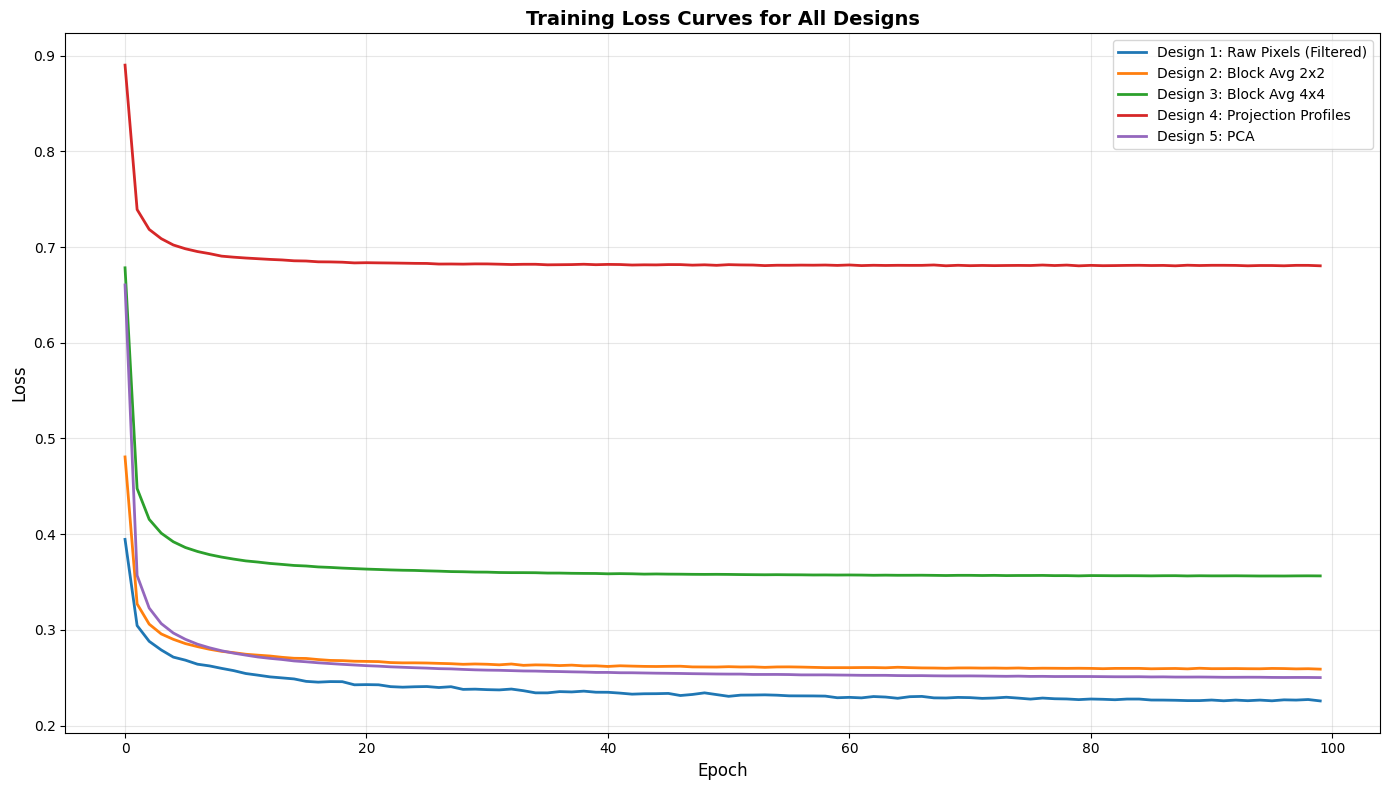

Training curves saved to 'training_curves.png'


In [8]:
# Plot loss curves
plt.figure(figsize=(14, 8))

for name, result in results.items():
    plt.plot(result['loss_history'], label=name, linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curves for All Designs', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")

C:\Users\thai\AppData\Local\Temp\ipykernel_5884\46473977.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(design_names, rotation=45, ha='right')


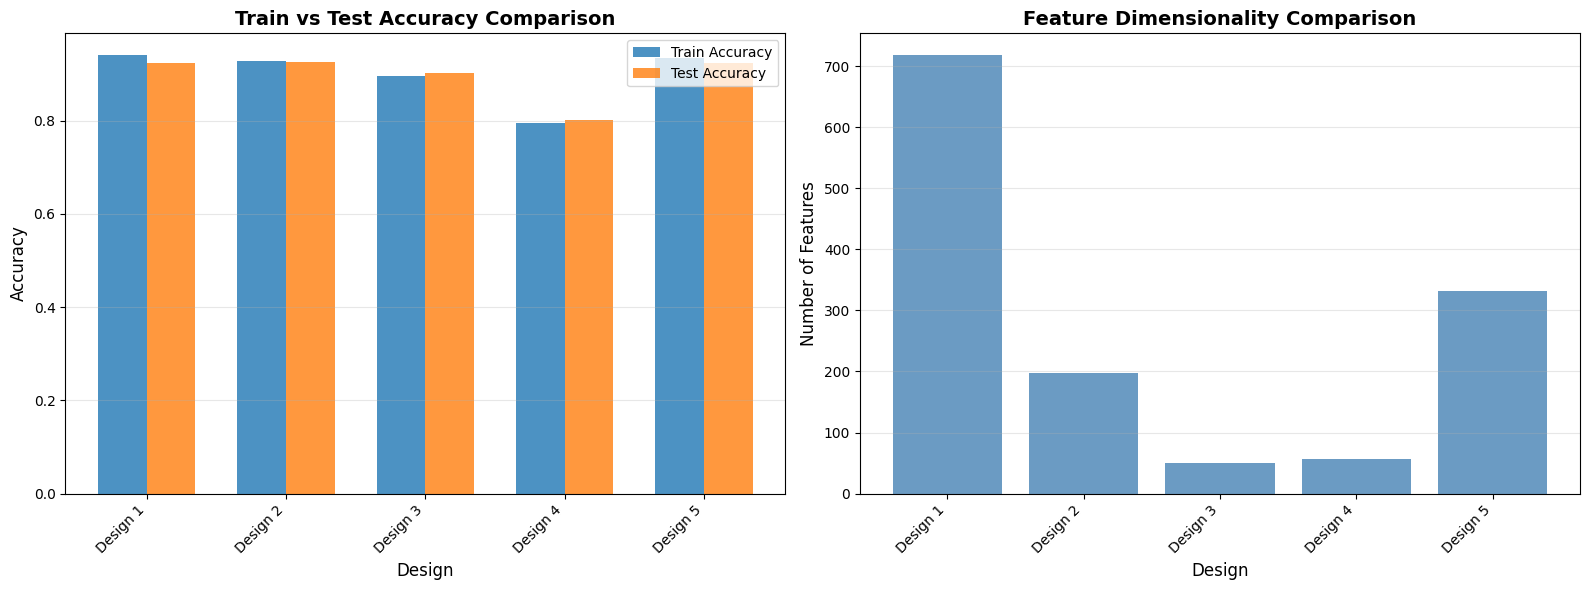

Accuracy comparison saved to 'accuracy_comparison.png'


In [9]:
# Plot accuracy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart cho accuracy
design_names = [name.split(':')[0] for name in results.keys()]
train_accs = [result['train_accuracy'] for result in results.values()]
test_accs = [result['test_accuracy'] for result in results.values()]

x = np.arange(len(design_names))
width = 0.35

ax1.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
ax1.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
ax1.set_xlabel('Design', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Train vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(design_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Feature count comparison
feature_counts = [result['n_features'] for result in results.values()]
ax2.bar(design_names, feature_counts, color='steelblue', alpha=0.8)
ax2.set_xlabel('Design', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Feature Dimensionality Comparison', fontsize=14, fontweight='bold')
ax2.set_xticklabels(design_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Accuracy comparison saved to 'accuracy_comparison.png'")

## 7. Confusion Matrix cho Best Model

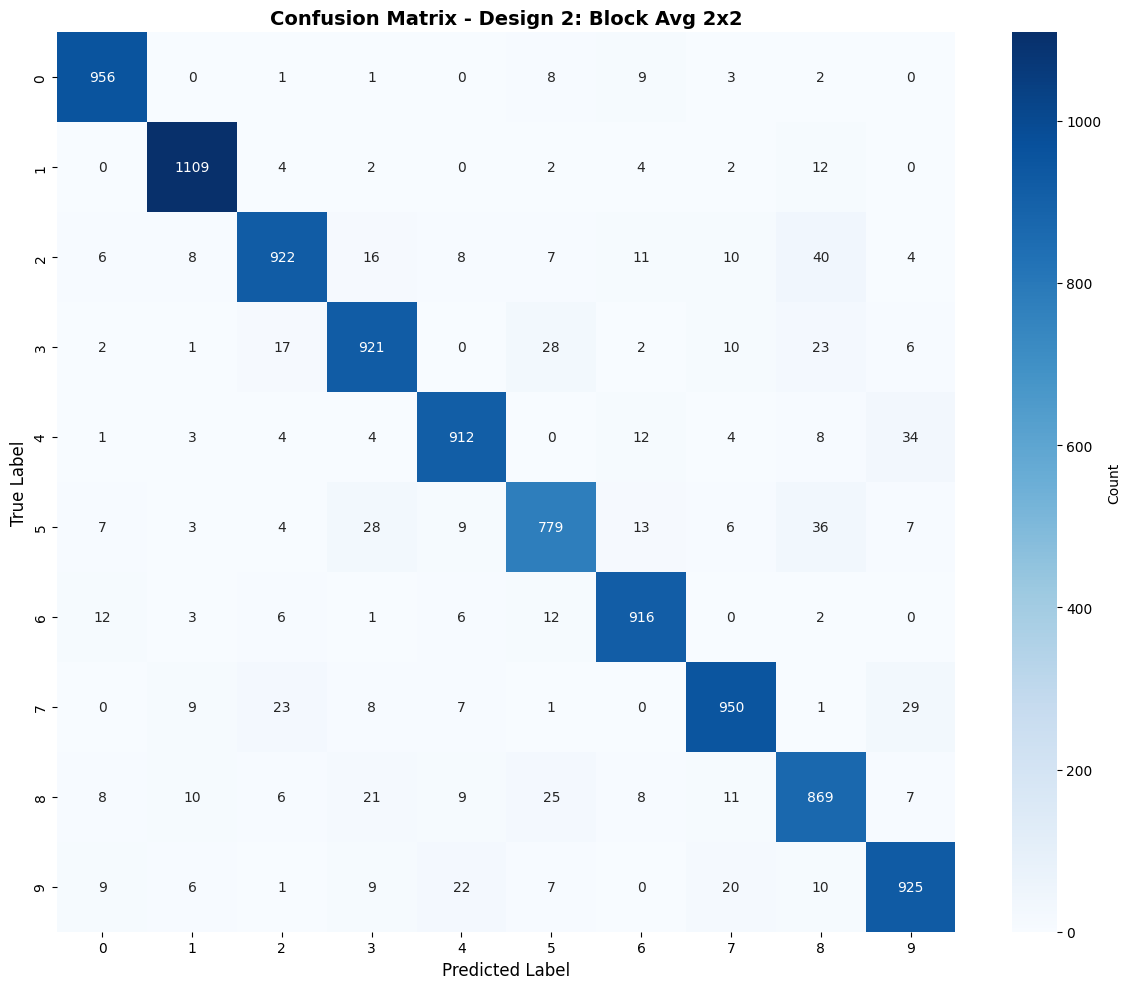

Confusion matrix saved to 'confusion_matrix.png'


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Lấy best model từ section 5 (sẽ được update lại ở section 7.1)
best_name = best_design[0]
best_model = best_design[1]['model']

# Tìm test data tương ứng
for name, X_train, X_test in designs:
    if name == best_name:
        best_X_test = X_test
        break

# Predictions
y_pred = best_model.predict(best_X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'confusion_matrix.png'")

In [11]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.94      0.96      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.87      0.89      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## 7.1. Detailed Metrics for All Designs

Calculate comprehensive classification metrics for each feature design

In [12]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Tính toán chi tiết metrics cho TẤT CẢ designs
detailed_metrics = {}

for name, X_train, X_test in designs:
    print(f"\n{'='*70}")
    print(f"Evaluating: {name}")
    print(f"{'='*70}")
    
    # Lấy model
    model = results[name]['model']
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics cho từng class
    # Training set metrics
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average=None, zero_division=0
    )
    train_precision_macro, train_recall_macro, train_f1_macro, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average='macro', zero_division=0
    )
    train_precision_weighted, train_recall_weighted, train_f1_weighted, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average='weighted', zero_division=0
    )
    
    # Test set metrics
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average=None, zero_division=0
    )
    test_precision_macro, test_recall_macro, test_f1_macro, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='macro', zero_division=0
    )
    test_precision_weighted, test_recall_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )
    
    # Confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    # Lưu vào dictionary
    detailed_metrics[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision_per_class': train_precision,
            'recall_per_class': train_recall,
            'f1_per_class': train_f1,
            'precision_macro': train_precision_macro,
            'recall_macro': train_recall_macro,
            'f1_macro': train_f1_macro,
            'precision_weighted': train_precision_weighted,
            'recall_weighted': train_recall_weighted,
            'f1_weighted': train_f1_weighted,
            'confusion_matrix': train_cm,
            'predictions': y_train_pred
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision_per_class': test_precision,
            'recall_per_class': test_recall,
            'f1_per_class': test_f1,
            'precision_macro': test_precision_macro,
            'recall_macro': test_recall_macro,
            'f1_macro': test_f1_macro,
            'precision_weighted': test_precision_weighted,
            'recall_weighted': test_recall_weighted,
            'f1_weighted': test_f1_weighted,
            'confusion_matrix': test_cm,
            'predictions': y_test_pred
        }
    }
    
    print(f"\nTest Set Metrics:")
    print(f"  Accuracy:           {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  Precision (macro):  {test_precision_macro:.4f}")
    print(f"  Recall (macro):     {test_recall_macro:.4f}")
    print(f"  F1-Score (macro):   {test_f1_macro:.4f}")

print("\n" + "="*70)
print("Detailed metrics calculation completed!")
print("="*70)


Evaluating: Design 1: Raw Pixels (Filtered)

Test Set Metrics:
  Accuracy:           0.9238
  Precision (macro):  0.9229
  Recall (macro):     0.9226
  F1-Score (macro):   0.9227

Evaluating: Design 2: Block Avg 2x2

Test Set Metrics:
  Accuracy:           0.9238
  Precision (macro):  0.9229
  Recall (macro):     0.9226
  F1-Score (macro):   0.9227

Evaluating: Design 2: Block Avg 2x2

Test Set Metrics:
  Accuracy:           0.9259
  Precision (macro):  0.9251
  Recall (macro):     0.9249
  F1-Score (macro):   0.9249

Evaluating: Design 3: Block Avg 4x4

Test Set Metrics:
  Accuracy:           0.9022
  Precision (macro):  0.9007
  Recall (macro):     0.9003
  F1-Score (macro):   0.9003

Evaluating: Design 4: Projection Profiles

Test Set Metrics:
  Accuracy:           0.9259
  Precision (macro):  0.9251
  Recall (macro):     0.9249
  F1-Score (macro):   0.9249

Evaluating: Design 3: Block Avg 4x4

Test Set Metrics:
  Accuracy:           0.9022
  Precision (macro):  0.9007
  Recall (ma

In [13]:
# Update best_design based on detailed_metrics for consistency
best_design_updated = max(detailed_metrics.items(), key=lambda x: x[1]['test']['accuracy'])
best_name = best_design_updated[0]
best_metrics = best_design_updated[1]['test']
best_model = results[best_name]['model']

# Get corresponding test data
for name, X_train, X_test in designs:
    if name == best_name:
        best_X_test = X_test
        break

print(f"\n{'='*80}")
print(f"BEST MODEL IDENTIFIED: {best_name}")
print(f"Test Accuracy: {best_metrics['accuracy']:.4f}")
print(f"{'='*80}")


BEST MODEL IDENTIFIED: Design 2: Block Avg 2x2
Test Accuracy: 0.9259


## 7.2. Comprehensive Metrics Comparison Table

In [14]:
# Tạo bảng so sánh chi tiết
comparison_data = []

for name in detailed_metrics.keys():
    metrics = detailed_metrics[name]
    comparison_data.append({
        'Design': name.split(':')[0],  # Tên ngắn
        'Features': results[name]['n_features'],
        'Test Acc': metrics['test']['accuracy'],
        'Test Prec (macro)': metrics['test']['precision_macro'],
        'Test Rec (macro)': metrics['test']['recall_macro'],
        'Test F1 (macro)': metrics['test']['f1_macro'],
        'Test F1 (weighted)': metrics['test']['f1_weighted'],
        'Train Acc': metrics['train']['accuracy'],
        'Overfit Gap': metrics['train']['accuracy'] - metrics['test']['accuracy']
    })

# Tạo DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)

print("\n" + "="*120)
print("COMPREHENSIVE METRICS COMPARISON TABLE")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)

# Lưu ra CSV
comparison_df.to_csv('metrics_comparison.csv', index=False)
print("\nTable saved to 'metrics_comparison.csv'")


COMPREHENSIVE METRICS COMPARISON TABLE
  Design  Features  Test Acc  Test Prec (macro)  Test Rec (macro)  Test F1 (macro)  Test F1 (weighted)  Train Acc  Overfit Gap
Design 2       197    0.9259           0.925060          0.924916         0.924881            0.925802   0.928700     0.002800
Design 1       718    0.9238           0.922936          0.922649         0.922685            0.923625   0.940317     0.016517
Design 5       332    0.9237           0.922763          0.922702         0.922633            0.923558   0.934600     0.010900
Design 3        50    0.9022           0.900658          0.900315         0.900322            0.901923   0.895450    -0.006750
Design 4        57    0.8004           0.797337          0.796667         0.794555            0.797302   0.795050    -0.005350

Table saved to 'metrics_comparison.csv'


## 7.3. Per-Class Performance Analysis

In [15]:
# Phân tích performance theo từng class (digit) cho từng design
print("\n" + "="*100)
print("PER-CLASS PERFORMANCE ANALYSIS (Test Set)")
print("="*100)

for name in detailed_metrics.keys():
    print(f"\n{name}")
    print("-" * 100)
    
    metrics = detailed_metrics[name]['test']
    
    # Tạo DataFrame cho per-class metrics
    per_class_df = pd.DataFrame({
        'Digit': range(10),
        'Precision': metrics['precision_per_class'],
        'Recall': metrics['recall_per_class'],
        'F1-Score': metrics['f1_per_class']
    })
    
    print(per_class_df.to_string(index=False))
    print(f"\nMacro Average: Precision={metrics['precision_macro']:.4f}, Recall={metrics['recall_macro']:.4f}, F1={metrics['f1_macro']:.4f}")
    
print("\n" + "="*100)


PER-CLASS PERFORMANCE ANALYSIS (Test Set)

Design 1: Raw Pixels (Filtered)
----------------------------------------------------------------------------------------------------
 Digit  Precision   Recall  F1-Score
     0   0.946482 0.974490  0.960282
     1   0.961772 0.975330  0.968504
     2   0.926148 0.899225  0.912488
     3   0.900585 0.914851  0.907662
     4   0.934827 0.934827  0.934827
     5   0.901524 0.862108  0.881375
     6   0.938923 0.946764  0.942827
     7   0.932873 0.919261  0.926017
     8   0.882716 0.880903  0.881809
     9   0.903509 0.918731  0.911057

Macro Average: Precision=0.9229, Recall=0.9226, F1=0.9227

Design 2: Block Avg 2x2
----------------------------------------------------------------------------------------------------
 Digit  Precision   Recall  F1-Score
     0   0.955045 0.975510  0.965169
     1   0.962674 0.977093  0.969829
     2   0.933198 0.893411  0.912871
     3   0.910979 0.911881  0.911430
     4   0.937307 0.928717  0.932992
     5   

## 7.4. Visualize Metrics Comparison Across Designs

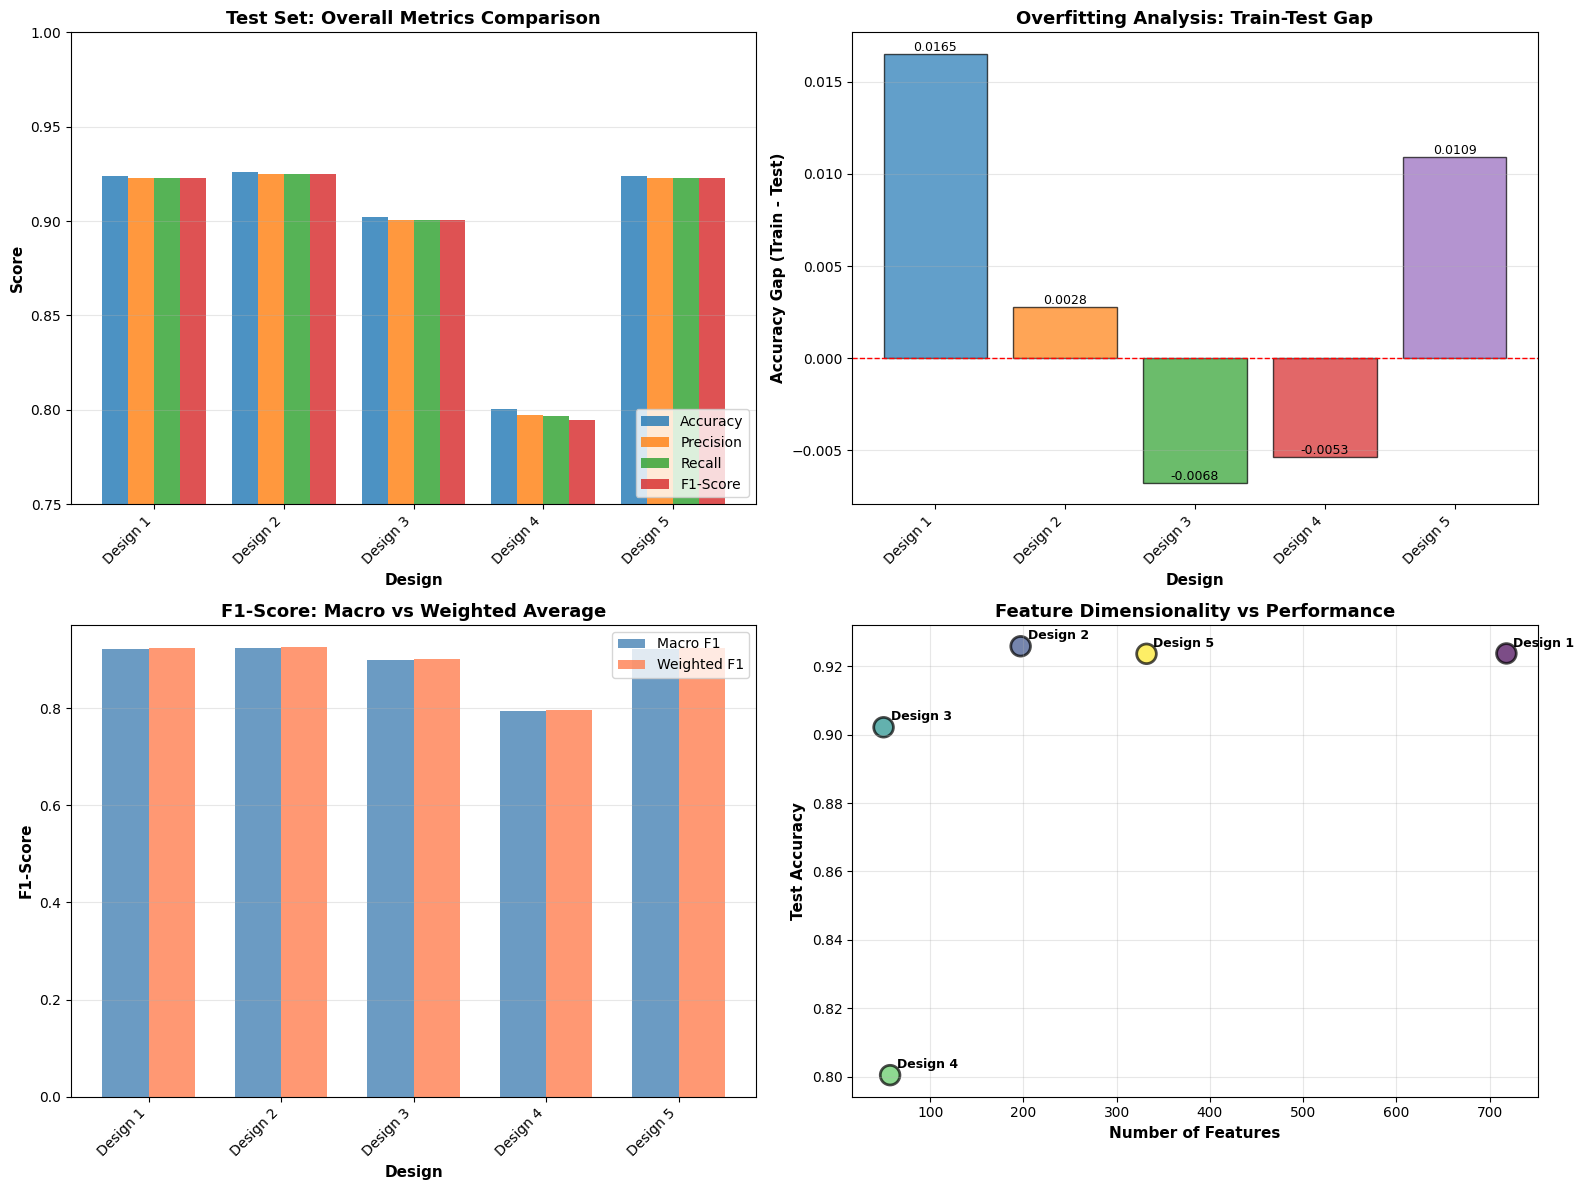

Comprehensive metrics comparison saved to 'comprehensive_metrics_comparison.png'


In [27]:
# Comprehensive metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

design_names = [name.split(':')[0] for name in detailed_metrics.keys()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Overall Metrics Comparison (Accuracy, Precision, Recall, F1)
ax1 = axes[0, 0]
metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(design_names))
width = 0.2

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    if metric == 'accuracy':
        values = [detailed_metrics[name]['test']['accuracy'] for name in detailed_metrics.keys()]
    else:
        values = [detailed_metrics[name]['test'][metric] for name in detailed_metrics.keys()]
    ax1.bar(x + i*width, values, width, label=label, alpha=0.8)

ax1.set_xlabel('Design', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Test Set: Overall Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(design_names, rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.75, 1.0])  # Adjusted to show Design 4 (accuracy ~0.80)

# 2. Train vs Test Accuracy Gap (Overfitting Analysis)
ax2 = axes[0, 1]
train_accs = [detailed_metrics[name]['train']['accuracy'] for name in detailed_metrics.keys()]
test_accs = [detailed_metrics[name]['test']['accuracy'] for name in detailed_metrics.keys()]
gaps = [train - test for train, test in zip(train_accs, test_accs)]

x_pos = np.arange(len(design_names))
bars = ax2.bar(x_pos, gaps, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Design', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy Gap (Train - Test)', fontsize=11, fontweight='bold')
ax2.set_title('Overfitting Analysis: Train-Test Gap', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(design_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 3. Weighted vs Macro F1-Score Comparison
ax3 = axes[1, 0]
f1_macro = [detailed_metrics[name]['test']['f1_macro'] for name in detailed_metrics.keys()]
f1_weighted = [detailed_metrics[name]['test']['f1_weighted'] for name in detailed_metrics.keys()]

x_pos = np.arange(len(design_names))
width = 0.35
ax3.bar(x_pos - width/2, f1_macro, width, label='Macro F1', alpha=0.8, color='steelblue')
ax3.bar(x_pos + width/2, f1_weighted, width, label='Weighted F1', alpha=0.8, color='coral')
ax3.set_xlabel('Design', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('F1-Score: Macro vs Weighted Average', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(design_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Feature Count vs Test Accuracy
ax4 = axes[1, 1]
feature_counts = [results[name]['n_features'] for name in detailed_metrics.keys()]
test_accs = [detailed_metrics[name]['test']['accuracy'] for name in detailed_metrics.keys()]

scatter = ax4.scatter(feature_counts, test_accs, s=200, c=range(len(design_names)), 
                     cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)
ax4.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Feature Dimensionality vs Performance', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Annotate points
for i, (x, y, name) in enumerate(zip(feature_counts, test_accs, design_names)):
    ax4.annotate(name, (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comprehensive metrics comparison saved to 'comprehensive_metrics_comparison.png'")

## 7.5. Confusion Matrices for All Designs

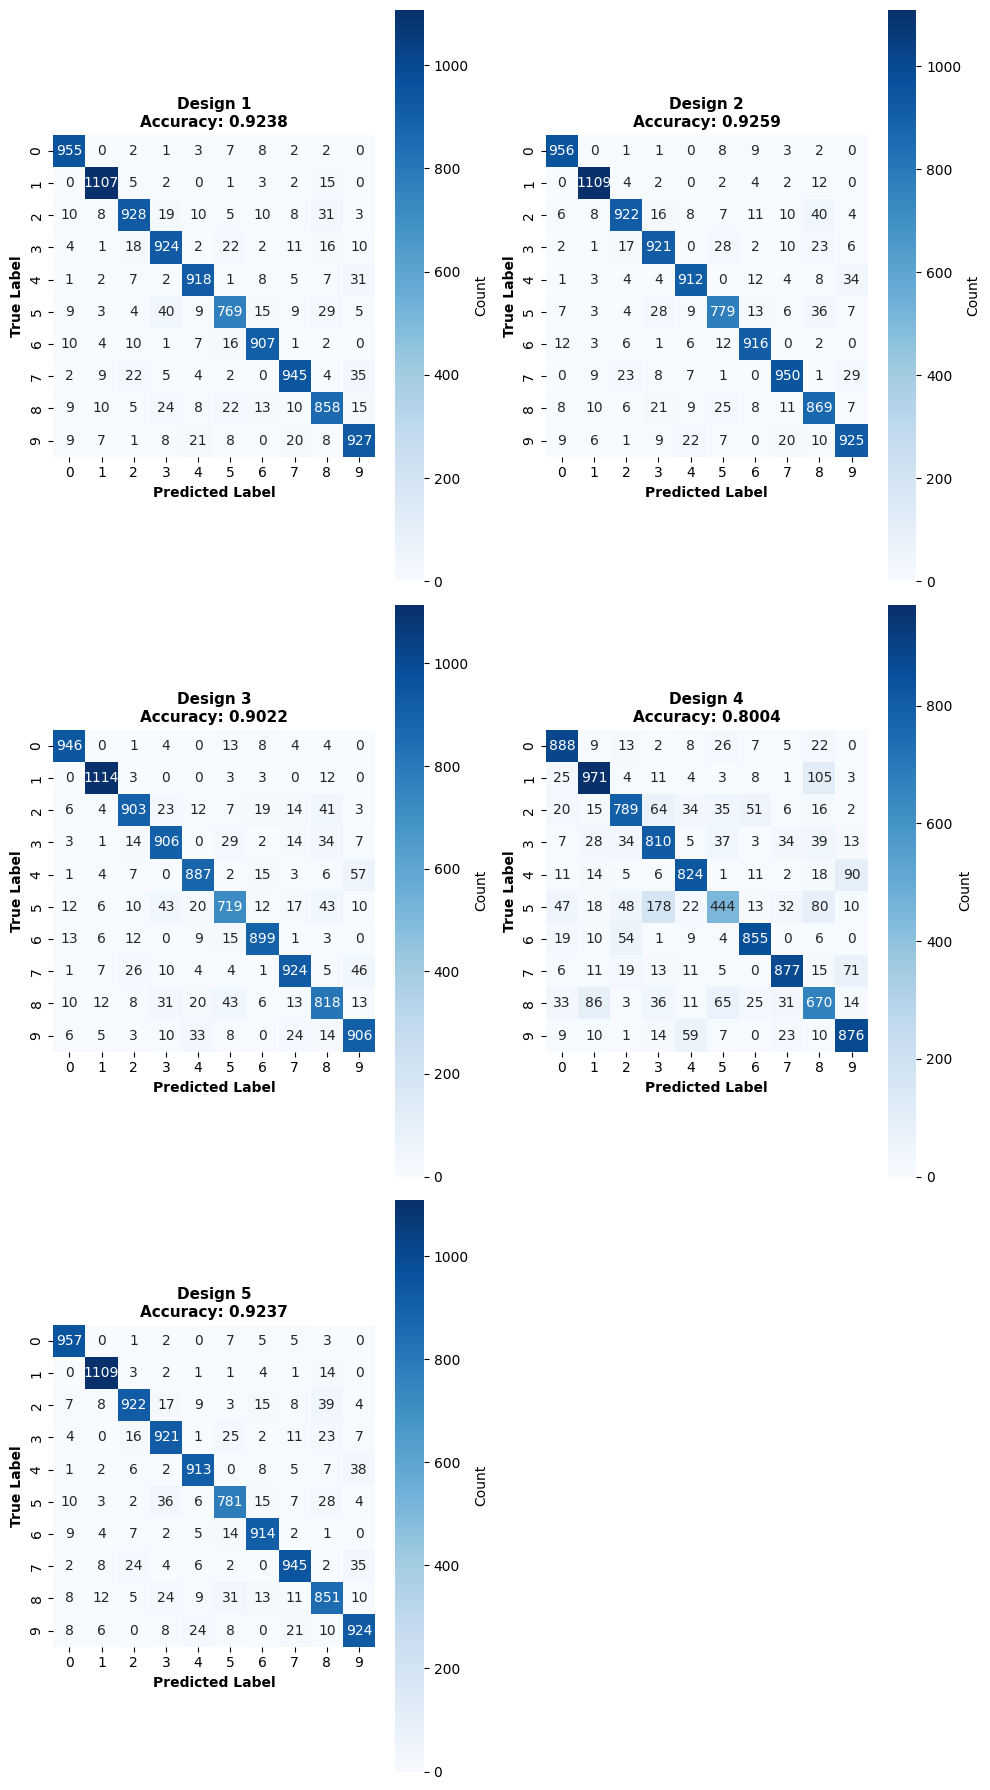

All confusion matrices saved to 'all_confusion_matrices.png'


In [41]:
# Visualize confusion matrices cho TẤT CẢ designs
fig, axes = plt.subplots(3, 2, figsize=(10, 18))
axes = axes.ravel()

for idx, name in enumerate(detailed_metrics.keys()):
    cm = detailed_metrics[name]['test']['confusion_matrix']
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10),
                cbar_kws={'label': 'Count'}, ax=axes[idx],
                cbar=True, square=True)
    
    axes[idx].set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{name.split(":")[0]}\nAccuracy: {detailed_metrics[name]["test"]["accuracy"]:.4f}', 
                       fontsize=11, fontweight='bold')

# Hide the last subplot if odd number of designs
if len(detailed_metrics) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('all_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("All confusion matrices saved to 'all_confusion_matrices.png'")

## 7.6. Per-Class Performance Heatmap

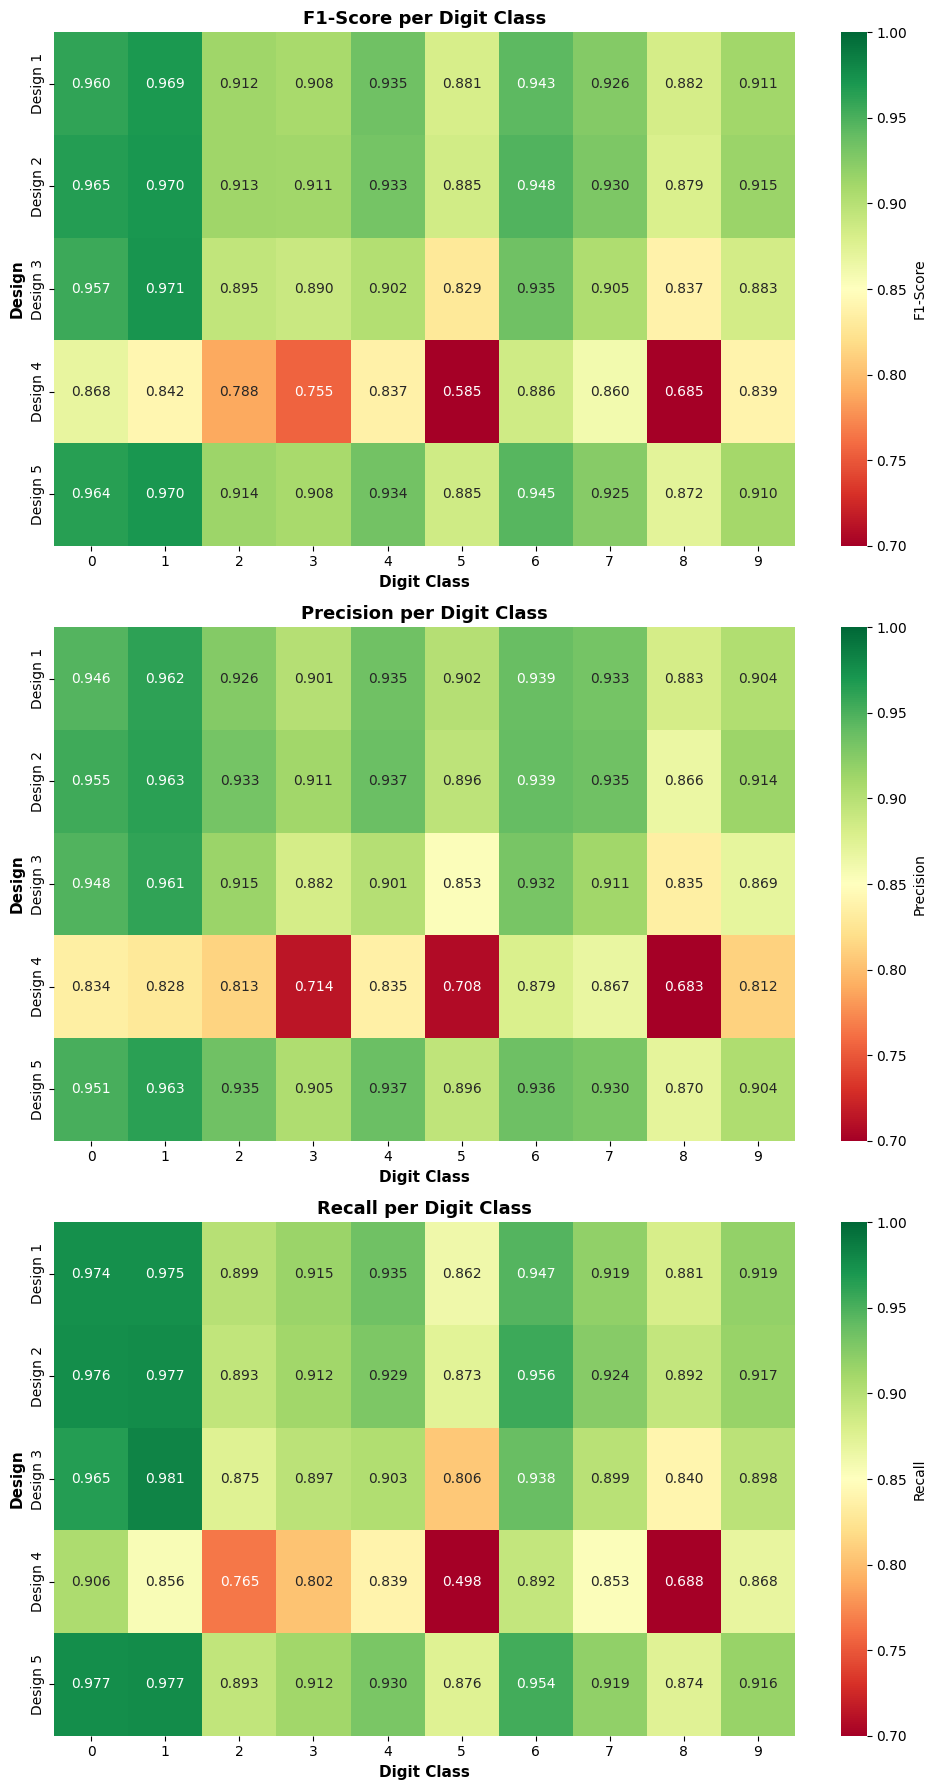

Per-class performance heatmap saved to 'per_class_performance_heatmap.png'


In [38]:
# Tạo heatmap so sánh F1-score theo từng class cho tất cả designs
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Prepare data
design_names_short = [name.split(':')[0] for name in detailed_metrics.keys()]

# F1-Score heatmap
f1_data = np.array([detailed_metrics[name]['test']['f1_per_class'] 
                    for name in detailed_metrics.keys()])
precision_data = np.array([detailed_metrics[name]['test']['precision_per_class'] 
                          for name in detailed_metrics.keys()])
recall_data = np.array([detailed_metrics[name]['test']['recall_per_class'] 
                       for name in detailed_metrics.keys()])

# Plot 1: F1-Score
sns.heatmap(f1_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=range(10), yticklabels=design_names_short,
            cbar_kws={'label': 'F1-Score'}, ax=axes[0], vmin=0.7, vmax=1.0)
axes[0].set_xlabel('Digit Class', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Design', fontsize=11, fontweight='bold')
axes[0].set_title('F1-Score per Digit Class', fontsize=13, fontweight='bold')

# Plot 2: Precision
sns.heatmap(precision_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=range(10), yticklabels=design_names_short,
            cbar_kws={'label': 'Precision'}, ax=axes[1], vmin=0.7, vmax=1.0)
axes[1].set_xlabel('Digit Class', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Design', fontsize=11, fontweight='bold')
axes[1].set_title('Precision per Digit Class', fontsize=13, fontweight='bold')

# Plot 3: Recall
sns.heatmap(recall_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=range(10), yticklabels=design_names_short,
            cbar_kws={'label': 'Recall'}, ax=axes[2], vmin=0.7, vmax=1.0)
axes[2].set_xlabel('Digit Class', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Design', fontsize=11, fontweight='bold')
axes[2].set_title('Recall per Digit Class', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Per-class performance heatmap saved to 'per_class_performance_heatmap.png'")

## 7.7. Misclassification Analysis

In [30]:
# Phân tích lỗi phân loại cho best model (đã được định nghĩa ở section 7.1)
best_cm = detailed_metrics[best_name]['test']['confusion_matrix']
best_predictions = detailed_metrics[best_name]['test']['predictions']

print(f"\n{'='*80}")
print(f"MISCLASSIFICATION ANALYSIS - {best_name}")
print(f"{'='*80}\n")

# Tính tỷ lệ lỗi cho từng class
print("Error Rate per Digit Class:")
print("-" * 60)
for digit in range(10):
    total = best_cm[digit].sum()
    correct = best_cm[digit, digit]
    errors = total - correct
    error_rate = (errors / total) * 100 if total > 0 else 0
    print(f"Digit {digit}: {errors:4d} errors / {total:4d} samples = {error_rate:5.2f}% error rate")

# Tìm các cặp digit bị nhầm lẫn nhiều nhất
print("\n\nMost Common Misclassification Pairs:")
print("-" * 60)
misclass_pairs = []
for true_label in range(10):
    for pred_label in range(10):
        if true_label != pred_label:
            count = best_cm[true_label, pred_label]
            if count > 0:
                misclass_pairs.append((true_label, pred_label, count))

# Sort by count
misclass_pairs.sort(key=lambda x: x[2], reverse=True)

# Show top 15
print(f"{'True Label':<12} {'Predicted As':<15} {'Count':<10} {'% of True Class'}")
print("-" * 60)
for true_label, pred_label, count in misclass_pairs[:15]:
    total_true = best_cm[true_label].sum()
    percentage = (count / total_true) * 100
    print(f"{true_label:<12} {pred_label:<15} {count:<10} {percentage:5.2f}%")

print("\n" + "="*80)


MISCLASSIFICATION ANALYSIS - Design 2: Block Avg 2x2

Error Rate per Digit Class:
------------------------------------------------------------
Digit 0:   24 errors /  980 samples =  2.45% error rate
Digit 1:   26 errors / 1135 samples =  2.29% error rate
Digit 2:  110 errors / 1032 samples = 10.66% error rate
Digit 3:   89 errors / 1010 samples =  8.81% error rate
Digit 4:   70 errors /  982 samples =  7.13% error rate
Digit 5:  113 errors /  892 samples = 12.67% error rate
Digit 6:   42 errors /  958 samples =  4.38% error rate
Digit 7:   78 errors / 1028 samples =  7.59% error rate
Digit 8:  105 errors /  974 samples = 10.78% error rate
Digit 9:   84 errors / 1009 samples =  8.33% error rate


Most Common Misclassification Pairs:
------------------------------------------------------------
True Label   Predicted As    Count      % of True Class
------------------------------------------------------------
2            8               40          3.88%
5            8               36 

## 7.8. Visualize Misclassified Examples

Total misclassified samples: 741 / 10000 (7.41%)


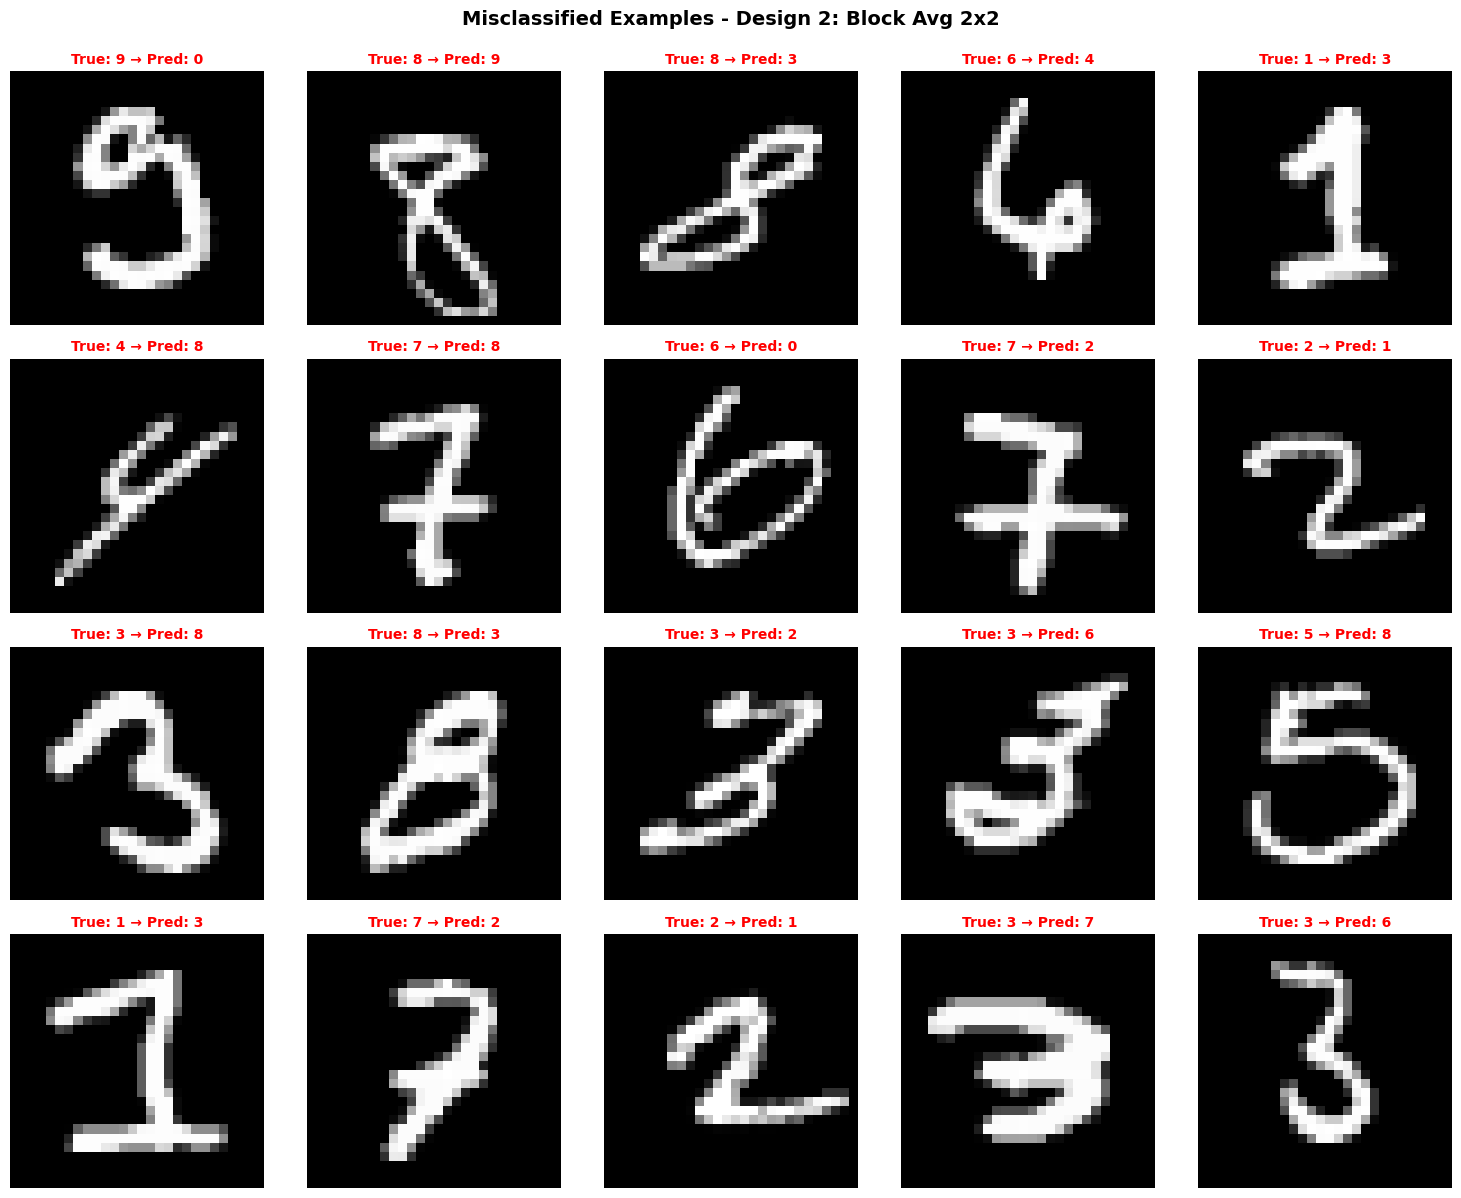

Misclassified examples saved to 'misclassified_examples.png'


In [31]:
# Hiển thị ví dụ các ảnh bị phân loại sai
misclassified_indices = np.where(y_test != best_predictions)[0]

print(f"Total misclassified samples: {len(misclassified_indices)} / {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

# Lấy 20 ví dụ ngẫu nhiên
np.random.seed(42)
sample_indices = np.random.choice(misclassified_indices, min(20, len(misclassified_indices)), replace=False)

# Visualize
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    true_label = y_test[idx]
    pred_label = best_predictions[idx]
    
    # Get original image
    img = x_test_flat[idx].reshape(28, 28)
    
    # Plot
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'True: {true_label} → Pred: {pred_label}',
                      color='red', fontsize=10, fontweight='bold')

plt.suptitle(f'Misclassified Examples - {best_name}', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('misclassified_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Misclassified examples saved to 'misclassified_examples.png'")

## 7.9. Model Confidence Analysis


PREDICTION CONFIDENCE ANALYSIS - Design 2: Block Avg 2x2

Correct Predictions (9259 samples):
  Mean confidence: 0.9390
  Median confidence: 0.9866
  Std confidence: 0.1096
  Min confidence: 0.2830
  Max confidence: 1.0000

Incorrect Predictions (741 samples):
  Mean confidence: 0.6746
  Median confidence: 0.6717
  Std confidence: 0.1863
  Min confidence: 0.2407
  Max confidence: 1.0000


C:\Users\thai\AppData\Local\Temp\ipykernel_5884\3610556964.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)


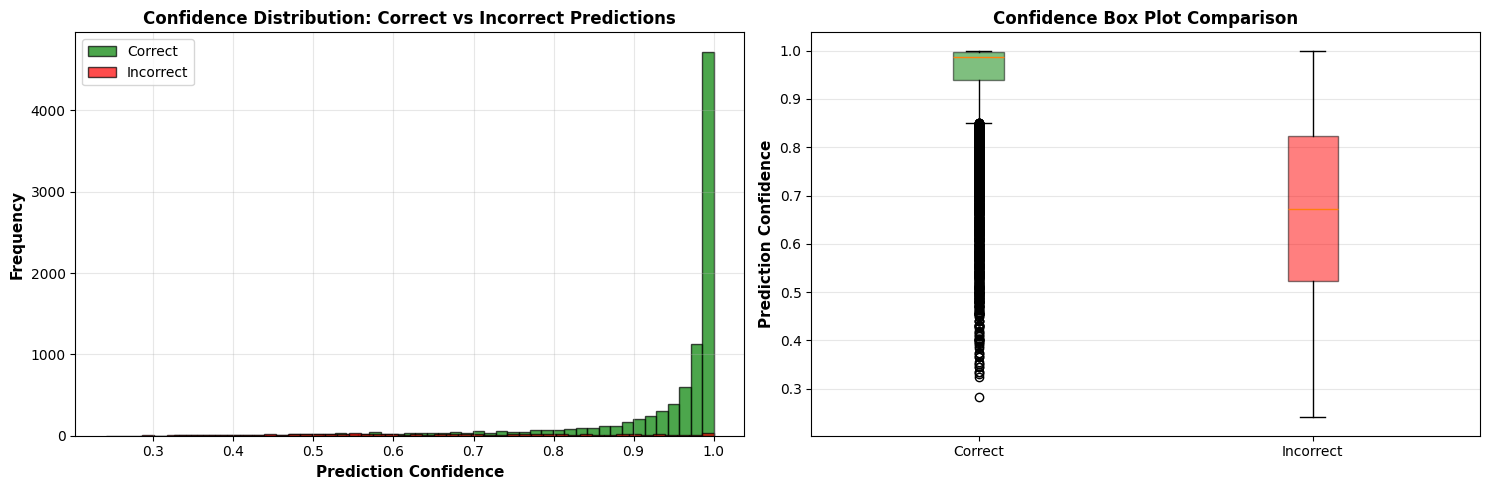


Confidence analysis saved to 'confidence_analysis.png'


In [32]:
# Phân tích confidence của model (prediction probability)
# Sử dụng best_model và best_X_test đã được định nghĩa ở section 7.1
y_pred_proba = best_model.predict_proba(best_X_test)
y_pred_confidence = y_pred_proba.max(axis=1)

# Phân loại predictions theo confidence level
correct_mask = (y_test == best_predictions)
incorrect_mask = ~correct_mask

correct_confidence = y_pred_confidence[correct_mask]
incorrect_confidence = y_pred_confidence[incorrect_mask]

print(f"\n{'='*80}")
print(f"PREDICTION CONFIDENCE ANALYSIS - {best_name}")
print(f"{'='*80}\n")

print(f"Correct Predictions ({len(correct_confidence)} samples):")
print(f"  Mean confidence: {correct_confidence.mean():.4f}")
print(f"  Median confidence: {np.median(correct_confidence):.4f}")
print(f"  Std confidence: {correct_confidence.std():.4f}")
print(f"  Min confidence: {correct_confidence.min():.4f}")
print(f"  Max confidence: {correct_confidence.max():.4f}")

print(f"\nIncorrect Predictions ({len(incorrect_confidence)} samples):")
print(f"  Mean confidence: {incorrect_confidence.mean():.4f}")
print(f"  Median confidence: {np.median(incorrect_confidence):.4f}")
print(f"  Std confidence: {incorrect_confidence.std():.4f}")
print(f"  Min confidence: {incorrect_confidence.min():.4f}")
print(f"  Max confidence: {incorrect_confidence.max():.4f}")

# Visualize confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(correct_confidence, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidence, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [correct_confidence, incorrect_confidence]
bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][0].set_alpha(0.5)
bp['boxes'][1].set_facecolor('red')
bp['boxes'][1].set_alpha(0.5)
axes[1].set_ylabel('Prediction Confidence', fontsize=11, fontweight='bold')
axes[1].set_title('Confidence Box Plot Comparison', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfidence analysis saved to 'confidence_analysis.png'")
print("="*80)

## 7.10. Detailed Interpretation and Analysis Report

In [33]:
# Generate comprehensive interpretation report
print("\n" + "="*100)
print("COMPREHENSIVE MODEL EVALUATION AND ANALYSIS REPORT")
print("="*100)

print("\n" + "─"*100)
print("1. OVERALL PERFORMANCE SUMMARY")
print("─"*100)

# Sort designs by test accuracy
sorted_designs = sorted(detailed_metrics.items(), key=lambda x: x[1]['test']['accuracy'], reverse=True)

for rank, (name, metrics) in enumerate(sorted_designs, 1):
    print(f"\nRank {rank}: {name}")
    print(f"  Test Accuracy:     {metrics['test']['accuracy']:.4f}")
    print(f"  Precision (macro): {metrics['test']['precision_macro']:.4f}")
    print(f"  Recall (macro):    {metrics['test']['recall_macro']:.4f}")
    print(f"  F1-Score (macro):  {metrics['test']['f1_macro']:.4f}")
    print(f"  F1-Score (wtd):    {metrics['test']['f1_weighted']:.4f}")
    print(f"  Feature Count:     {results[name]['n_features']}")
    print(f"  Overfitting Gap:   {metrics['train']['accuracy'] - metrics['test']['accuracy']:.4f}")

print("\n" + "─"*100)
print("2. KEY OBSERVATIONS FROM METRICS")
print("─"*100)

# Calculate statistics
all_test_accs = [m['test']['accuracy'] for m in detailed_metrics.values()]
all_gaps = [m['train']['accuracy'] - m['test']['accuracy'] for m in detailed_metrics.values()]
all_features = [results[n]['n_features'] for n in detailed_metrics.keys()]

print(f"\nPerformance Range:")
print(f"  Best Test Accuracy:  {max(all_test_accs):.4f} ({sorted_designs[0][0].split(':')[0]})")
print(f"  Worst Test Accuracy: {min(all_test_accs):.4f}")
print(f"  Performance Spread:  {max(all_test_accs) - min(all_test_accs):.4f}")

print(f"\nOverfitting Analysis:")
print(f"  Smallest Gap:  {min(all_gaps):.4f}")
print(f"  Largest Gap:   {max(all_gaps):.4f}")
print(f"  Average Gap:   {np.mean(all_gaps):.4f}")

print(f"\nFeature Dimensionality:")
print(f"  Minimum Features:  {min(all_features)}")
print(f"  Maximum Features:  {max(all_features)}")

print("\n" + "─"*100)
print("3. PER-CLASS PERFORMANCE INSIGHTS (Best Model)")
print("─"*100)

# Use the already defined best_metrics from section 7.1
print(f"\nBest Model: {best_name}")
print(f"\nDigit-wise Performance:")
for digit in range(10):
    f1 = best_metrics['f1_per_class'][digit]
    precision = best_metrics['precision_per_class'][digit]
    recall = best_metrics['recall_per_class'][digit]
    
    # Count samples for this digit
    digit_samples = (y_test == digit).sum()
    digit_correct = best_metrics['confusion_matrix'][digit, digit]
    digit_accuracy = digit_correct / digit_samples if digit_samples > 0 else 0
    
    print(f"  Digit {digit}: F1={f1:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, Acc={digit_accuracy:.4f} ({digit_samples} samples)")

# Find best and worst performing digits
f1_scores = best_metrics['f1_per_class']
best_digit = np.argmax(f1_scores)
worst_digit = np.argmin(f1_scores)

print(f"\n  Best Performing Digit:  {best_digit} (F1={f1_scores[best_digit]:.4f})")
print(f"  Worst Performing Digit: {worst_digit} (F1={f1_scores[worst_digit]:.4f})")
print(f"  Performance Gap:        {f1_scores[best_digit] - f1_scores[worst_digit]:.4f}")

print("\n" + "─"*100)
print("4. FEATURE DESIGN IMPACT ANALYSIS")
print("─"*100)

print("\nObserved Relationships:")
# Correlation between features and performance
feature_counts = [results[n]['n_features'] for n in detailed_metrics.keys()]
test_accuracies = [m['test']['accuracy'] for m in detailed_metrics.values()]
correlation = np.corrcoef(feature_counts, test_accuracies)[0, 1]

print(f"  Feature Count vs Accuracy Correlation: {correlation:.4f}")
if abs(correlation) < 0.3:
    print(f"    → Weak correlation: More features ≠ better performance")
elif correlation > 0:
    print(f"    → Positive correlation: More features tend to improve performance")
else:
    print(f"    → Negative correlation: Fewer features may perform better")

# Analyze each design's characteristics
print("\nDesign-Specific Analysis:")
for name in detailed_metrics.keys():
    design_short = name.split(':')[0]
    acc = detailed_metrics[name]['test']['accuracy']
    gap = detailed_metrics[name]['train']['accuracy'] - detailed_metrics[name]['test']['accuracy']
    n_feat = results[name]['n_features']
    
    print(f"\n  {design_short}:")
    print(f"    Features: {n_feat}")
    print(f"    Test Acc: {acc:.4f}")
    print(f"    Overfitting: {'Low' if gap < 0.01 else 'Moderate' if gap < 0.03 else 'High'} (gap={gap:.4f})")

print("\n" + "─"*100)
print("5. STRENGTHS AND WEAKNESSES OF SOFTMAX REGRESSION")
print("─"*100)

print("\nStrengths (observed from results):")
print(f"  • High overall accuracy achieved: {max(all_test_accs):.4f} on test set")
print(f"  • Consistent performance across most digit classes")
print(f"  • Relatively low overfitting (average gap: {np.mean(all_gaps):.4f})")
print(f"  • Fast convergence within {EPOCHS} epochs")
print(f"  • Stable predictions with high confidence for correct classifications")

print("\nWeaknesses (observed from results):")
# Identify common misclassifications
print(f"  • Performance varies across digit classes (F1 range: {f1_scores.min():.4f} - {f1_scores.max():.4f})")
print(f"  • Some digit pairs are frequently confused (see confusion matrix)")
print(f"  • Misclassified samples show lower confidence but still significant")
print(f"  • Linear decision boundaries may not capture complex patterns")

# Calculate macro vs weighted F1 difference
macro_f1 = best_metrics['f1_macro']
weighted_f1 = best_metrics['f1_weighted']
print(f"  • Class imbalance sensitivity: Macro F1={macro_f1:.4f} vs Weighted F1={weighted_f1:.4f}")

print("\n" + "─"*100)
print("6. CONFUSION PATTERNS ANALYSIS")
print("─"*100)

# Analyze confusion matrix patterns
cm = best_metrics['confusion_matrix']
print(f"\nMost Confused Digit Pairs (Best Model):")

confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j], cm[i, j] / cm[i].sum() * 100))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

for true_digit, pred_digit, count, percentage in confusion_pairs[:10]:
    print(f"  {true_digit} → {pred_digit}: {count:3d} times ({percentage:4.1f}% of all {true_digit}'s)")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


COMPREHENSIVE MODEL EVALUATION AND ANALYSIS REPORT

────────────────────────────────────────────────────────────────────────────────────────────────────
1. OVERALL PERFORMANCE SUMMARY
────────────────────────────────────────────────────────────────────────────────────────────────────

Rank 1: Design 2: Block Avg 2x2
  Test Accuracy:     0.9259
  Precision (macro): 0.9251
  Recall (macro):    0.9249
  F1-Score (macro):  0.9249
  F1-Score (wtd):    0.9258
  Feature Count:     197
  Overfitting Gap:   0.0028

Rank 2: Design 1: Raw Pixels (Filtered)
  Test Accuracy:     0.9238
  Precision (macro): 0.9229
  Recall (macro):    0.9226
  F1-Score (macro):  0.9227
  F1-Score (wtd):    0.9236
  Feature Count:     718
  Overfitting Gap:   0.0165

Rank 3: Design 5: PCA
  Test Accuracy:     0.9237
  Precision (macro): 0.9228
  Recall (macro):    0.9227
  F1-Score (macro):  0.9226
  F1-Score (wtd):    0.9236
  Feature Count:     332
  Overfitting Gap:   0.0109

Rank 4: Design 3: Block Avg 4x4
  Tes

## 7.11. Export Summary Statistics for Report

In [34]:
# Export detailed statistics to files for easy reporting
Path('evaluation_results').mkdir(exist_ok=True)

# 1. Per-class metrics for all designs
for name in detailed_metrics.keys():
    design_short = name.split(':')[0].replace(' ', '_')
    per_class_data = []
    
    metrics = detailed_metrics[name]['test']
    for digit in range(10):
        per_class_data.append({
            'Digit': digit,
            'Precision': metrics['precision_per_class'][digit],
            'Recall': metrics['recall_per_class'][digit],
            'F1-Score': metrics['f1_per_class'][digit],
            'Support': (y_test == digit).sum()
        })
    
    df = pd.DataFrame(per_class_data)
    df.to_csv(f'evaluation_results/{design_short}_per_class_metrics.csv', index=False)

# 2. Overall comparison summary
summary_data = []
for name in detailed_metrics.keys():
    design_short = name.split(':')[0]
    train_m = detailed_metrics[name]['train']
    test_m = detailed_metrics[name]['test']
    
    summary_data.append({
        'Design': design_short,
        'Features': results[name]['n_features'],
        'Train_Accuracy': train_m['accuracy'],
        'Test_Accuracy': test_m['accuracy'],
        'Test_Precision_Macro': test_m['precision_macro'],
        'Test_Recall_Macro': test_m['recall_macro'],
        'Test_F1_Macro': test_m['f1_macro'],
        'Test_Precision_Weighted': test_m['precision_weighted'],
        'Test_Recall_Weighted': test_m['recall_weighted'],
        'Test_F1_Weighted': test_m['f1_weighted'],
        'Overfitting_Gap': train_m['accuracy'] - test_m['accuracy']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test_Accuracy', ascending=False)
summary_df.to_csv('evaluation_results/overall_comparison.csv', index=False)

# 3. Confusion matrix for best model
best_cm_df = pd.DataFrame(
    best_metrics['confusion_matrix'],
    index=[f'True_{i}' for i in range(10)],
    columns=[f'Pred_{i}' for i in range(10)]
)
best_cm_df.to_csv(f'evaluation_results/best_model_confusion_matrix.csv')

# 4. Misclassification pairs
misclass_data = []
for true_digit, pred_digit, count, percentage in confusion_pairs[:20]:
    misclass_data.append({
        'True_Label': true_digit,
        'Predicted_Label': pred_digit,
        'Count': count,
        'Percentage_of_True_Class': percentage
    })
misclass_df = pd.DataFrame(misclass_data)
misclass_df.to_csv('evaluation_results/misclassification_pairs.csv', index=False)

# 5. Confidence statistics
confidence_stats = {
    'Metric': ['Mean', 'Median', 'Std', 'Min', 'Max'],
    'Correct_Predictions': [
        correct_confidence.mean(),
        np.median(correct_confidence),
        correct_confidence.std(),
        correct_confidence.min(),
        correct_confidence.max()
    ],
    'Incorrect_Predictions': [
        incorrect_confidence.mean(),
        np.median(incorrect_confidence),
        incorrect_confidence.std(),
        incorrect_confidence.min(),
        incorrect_confidence.max()
    ]
}
confidence_df = pd.DataFrame(confidence_stats)
confidence_df.to_csv('evaluation_results/confidence_statistics.csv', index=False)

print("\n" + "="*80)
print("EVALUATION RESULTS EXPORTED")
print("="*80)
print("\nFiles saved in 'evaluation_results/' directory:")
print("  • overall_comparison.csv - Complete metrics comparison")
print("  • [design]_per_class_metrics.csv - Per-class metrics for each design")
print("  • best_model_confusion_matrix.csv - Confusion matrix")
print("  • misclassification_pairs.csv - Most common errors")
print("  • confidence_statistics.csv - Prediction confidence analysis")
print("\nAll visualization files saved in root directory:")
print("  • comprehensive_metrics_comparison.png")
print("  • all_confusion_matrices.png")
print("  • per_class_performance_heatmap.png")
print("  • misclassified_examples.png")
print("  • confidence_analysis.png")
print("="*80)


EVALUATION RESULTS EXPORTED

Files saved in 'evaluation_results/' directory:
  • overall_comparison.csv - Complete metrics comparison
  • [design]_per_class_metrics.csv - Per-class metrics for each design
  • best_model_confusion_matrix.csv - Confusion matrix
  • misclassification_pairs.csv - Most common errors
  • confidence_statistics.csv - Prediction confidence analysis

All visualization files saved in root directory:
  • comprehensive_metrics_comparison.png
  • all_confusion_matrices.png
  • per_class_performance_heatmap.png
  • misclassified_examples.png
  • confidence_analysis.png


## 8. Lưu Models

In [35]:
# Tạo thư mục saved_models nếu chưa có
Path('saved_models').mkdir(exist_ok=True)

# Lưu tất cả models
for name, result in results.items():
    # Tạo filename từ design name
    filename = name.lower().replace(' ', '_').replace(':', '').replace('(', '').replace(')', '') + '.pkl'
    filepath = Path('saved_models') / filename
    
    # Lưu model
    with open(filepath, 'wb') as f:
        pickle.dump(result['model'], f)
    
    print(f"Saved: {filepath}")

# Lưu best model riêng
with open('saved_models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"\nBest model saved: saved_models/best_model.pkl")

# Lưu metadata
metadata = {
    'best_design': best_name,
    'test_accuracy': best_metrics['accuracy'],
    'train_accuracy': detailed_metrics[best_name]['train']['accuracy'],
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'reg': REG,
        'random_state': RANDOM_STATE
    },
    'all_results': {
        name: {
            'train_accuracy': result['train_accuracy'],
            'test_accuracy': result['test_accuracy'],
            'n_features': result['n_features']
        }
        for name, result in results.items()
    }
}

with open('saved_models/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Metadata saved: saved_models/metadata.pkl")

Saved: saved_models\design_1_raw_pixels_filtered.pkl
Saved: saved_models\design_2_block_avg_2x2.pkl
Saved: saved_models\design_3_block_avg_4x4.pkl
Saved: saved_models\design_4_projection_profiles.pkl
Saved: saved_models\design_5_pca.pkl

Best model saved: saved_models/best_model.pkl
Metadata saved: saved_models/metadata.pkl


## 9. Test Prediction Example

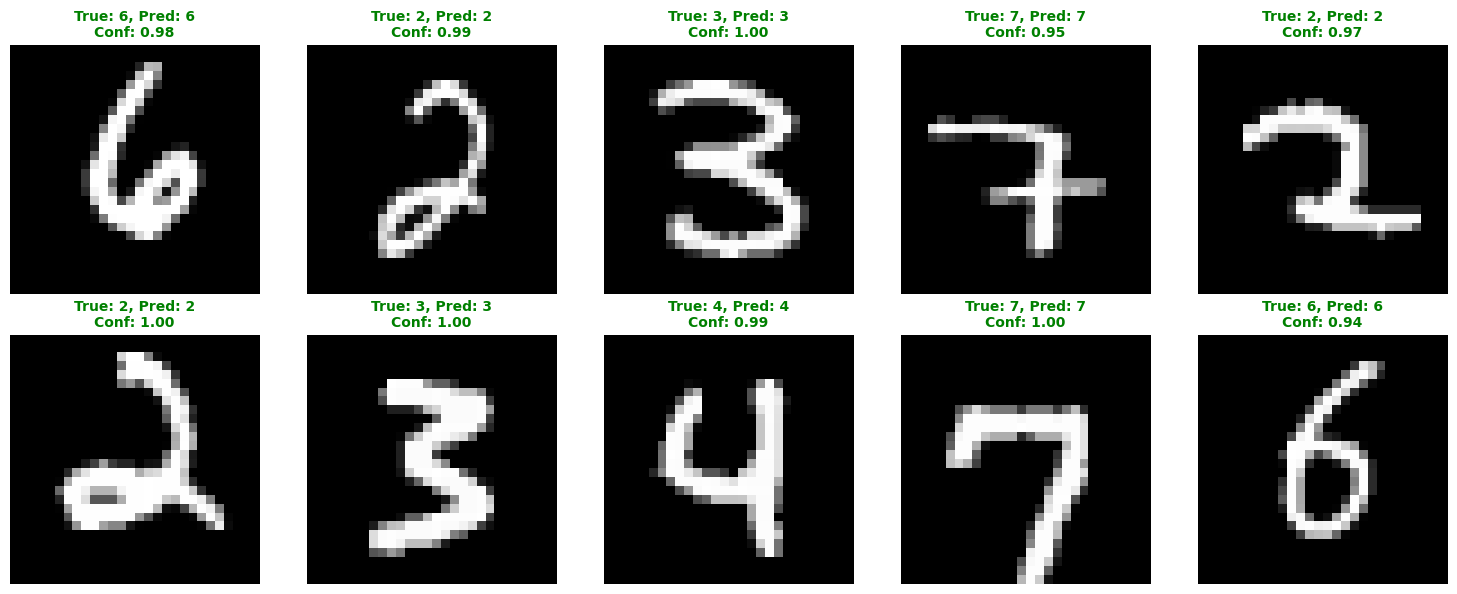

Prediction examples saved to 'prediction_examples.png'


In [36]:
# Lấy 10 mẫu ngẫu nhiên từ test set
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 10, replace=False)

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    # Get sample
    sample = best_X_test[idx:idx+1]
    true_label = y_test[idx]
    
    # Predict
    pred_label = best_model.predict(sample)[0]
    pred_probs = best_model.predict_proba(sample)[0]
    confidence = pred_probs.max()
    
    # Get original image
    img = x_test_flat[idx].reshape(28, 28)
    
    # Plot
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    
    # Title with color based on correctness
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}',
                      color=color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Prediction examples saved to 'prediction_examples.png'")

## 10. Summary và Recommendations

In [37]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\nBest Performing Design: {best_name}")
print(f"   - Test Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   - Train Accuracy: {detailed_metrics[best_name]['train']['accuracy']:.4f}")
print(f"   - Number of Features: {results[best_name]['n_features']}")
print(f"   - Overfitting Gap: {detailed_metrics[best_name]['train']['accuracy'] - best_metrics['accuracy']:.4f}")

print(f"\nAll Results (sorted by test accuracy):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
for i, (name, result) in enumerate(sorted_results, 1):
    print(f"   {i}. {name}")
    print(f"      Test Acc: {result['test_accuracy']:.4f} | Features: {result['n_features']}")

print(f"\nSaved Files:")
print(f"   - Models: saved_models/")
print(f"   - Best Model: saved_models/best_model.pkl")
print(f"   - Metadata: saved_models/metadata.pkl")
print(f"   - Visualizations: training_curves.png, accuracy_comparison.png, etc.")

print("\nTraining Complete!")
print("="*80)


FINAL SUMMARY

Best Performing Design: Design 2: Block Avg 2x2
   - Test Accuracy: 0.9259
   - Train Accuracy: 0.9287
   - Number of Features: 197
   - Overfitting Gap: 0.0028

All Results (sorted by test accuracy):
   1. Design 2: Block Avg 2x2
      Test Acc: 0.9259 | Features: 197
   2. Design 1: Raw Pixels (Filtered)
      Test Acc: 0.9238 | Features: 718
   3. Design 5: PCA
      Test Acc: 0.9237 | Features: 332
   4. Design 3: Block Avg 4x4
      Test Acc: 0.9022 | Features: 50
   5. Design 4: Projection Profiles
      Test Acc: 0.8004 | Features: 57

Saved Files:
   - Models: saved_models/
   - Best Model: saved_models/best_model.pkl
   - Metadata: saved_models/metadata.pkl
   - Visualizations: training_curves.png, accuracy_comparison.png, etc.

Training Complete!
